In [1]:
master_path = '..\..\Raw_Data\\Bioreactor_Data\\Single Pulse Experiments'

In [2]:
from lib.tools import *

In [3]:
def rec_multi_vessel(fig,data,colors, t_shift =0,t_del = [], light =False,norm =False,tc =False,stats =False):
    name = data.preculture.strain_name
    df_LEDs = data.data_to_df('LEDs')
    df_ODs = data.data_to_df('ODs')
    n_events = 5000
    t0 = df_ODs['time_s'].iloc[0]
    gk = data.cells.groupby('rel_time_hrs')
    t= np.unique(np.array(data.cells['rel_time_hrs']))
    t_del = sorted(t_del, reverse=True)
    t = np.delete(t,t_del)
    rec_frac_count = np.zeros(np.size(t),dtype=float)
    for jj in range(0,np.size(t)):
            lk = gk.get_group(t[jj])
            if (lk.size)/26 < n_events/100:
                print('Not enough cells yo read Kafka') 
            else:
                sz_lk = lk.loc[(lk['gating-metric'] >= thresh1)]
                dbf_lk = sz_lk.loc[(sz_lk['doublet-metric'] <= thresh2)]
                db_lk = dbf_lk.loc[(dbf_lk[fps[0]] > thresh_mc) |(dbf_lk[fps[1]] > thresh_mn) ]
               
                rec_frac_count[jj] = db_lk.loc[(((db_lk[fps[1]]/db_lk[fps[2]])*np.mean(db_lk[fps[2]]))>thresh_fp[1])][fps[1]].count()/db_lk[fps[1]].count()
                

                if stats ==True:
                    print('Total events acquired =  %d' %len(lk) )
                    size = 100*len(sz_lk)/len(lk)
                    print('Size gated cells were %0.3f percent of the population' %size )
                    sing = 100*len(dbf_lk)/len(sz_lk)
                    print('Singlets were %0.3f percent of the size gated population' %sing )
                    viable = 100*len(db_lk)/len(dbf_lk)
                    print('Viable cells were %0.3f percent of the singlets' %viable )
                    recs=rec_frac_count[jj]*100
                    print('Of the viable cells %0.3f percent were differentiated' %recs )

    if norm == True:
        rec_frac_count = (rec_frac_count -rec_frac_count[0])/(1-rec_frac_count[0])
        t = np.delete(t,0)
        rec_frac_count =np.delete(rec_frac_count,0)

    ax1.scatter(t-t_shift,rec_frac_count*100,s = sz , color=colors)


    ax1.set_xlabel('Time(h)')
    ax1.set_ylim(0, 105)
    ax1.set_xlim(0-t_shift, t[-1]-t_shift+4)

    ax1.set_ylabel('Differentiated Fraction (%)')
    if light ==True:
        ax2 = ax1.twinx()
        ax2.plot(df_LEDs['rel_time_hrs']-t_shift,df_LEDs['intensity'], c= '#5de8f0',lw = 2)
        ax2.set_ylim(0,max(df_LEDs['intensity'])+max(df_LEDs['intensity'])/10)
    return(t,rec_frac_count)

In [4]:
def hist_data(data,rid,fp,tps):
    data = data[rid]
    gk = data.cells.groupby('rel_time_hrs')
    t= np.unique(np.array(data.cells['rel_time_hrs']))
    hist_data = []
    for jj in range(1,np.size(t)+1):
        if jj>tps[1]:
            break
        if (jj > tps[0]) & (jj< tps[1]):
            lk = gk.get_group(t[jj-1])
            sz_lk = lk.loc[(lk['gating-metric'] >= thresh1)]
            dbf_lk = sz_lk.loc[(sz_lk['doublet-metric'] <= thresh2)]
            db_lk = dbf_lk.loc[(dbf_lk[fps[0]] > thresh_mc) |(dbf_lk[fps[1]] > thresh_mn) ]
            hist_data =  np.asarray(db_lk[fp]/db_lk['SSC-HLin']*db_lk['SSC-HLin'].mean())

    return(hist_data)

In [5]:
#Single Pulse Data

t=[x[1] for x in os.walk(master_path)]
basepath = os.path.join(master_path,'2021-02-09_Single_pulse_replicate_1')
basepath = os.path.join(basepath,t[1][0])
print(basepath)
all_data1 = {}
reactors = [1,2,3,4,5,6,7,8]
for rid in reactors:
        print(rid)
        all_data1[rid] = ReactorData(f'{basepath}/reactor-{rid}')
        all_data1[rid].cells = do_gating(all_data1[rid])
        all_data1[rid].cells= deconvolve_turbi(all_data1[rid].cells,AF,FP_signatures)
        
# Continuous light data        
basepath = os.path.join(master_path,'2021-03-15_Single_pulse_replicate_2')
basepath = os.path.join(basepath,t[1][0])
print(basepath)
all_data = {}
reactors = [8]
for rid in reactors:
        print(rid)
        all_data[rid] = ReactorData(f'{basepath}/reactor-{rid}')
        all_data[rid].cells = do_gating(all_data[rid])
        all_data[rid].cells= deconvolve_turbi(all_data[rid].cells,AF,FP_signatures)

..\..\Raw_Data\Bioreactor_Data\Single Pulse Experiments\2021-02-09_Single_pulse_replicate_1\reactor-data
1
done
2
done
3
done
4
done
5
done
6
done
7
done
8
done
..\..\Raw_Data\Bioreactor_Data\Single Pulse Experiments\2021-03-15_Single_pulse_replicate_2\reactor-data
8
done


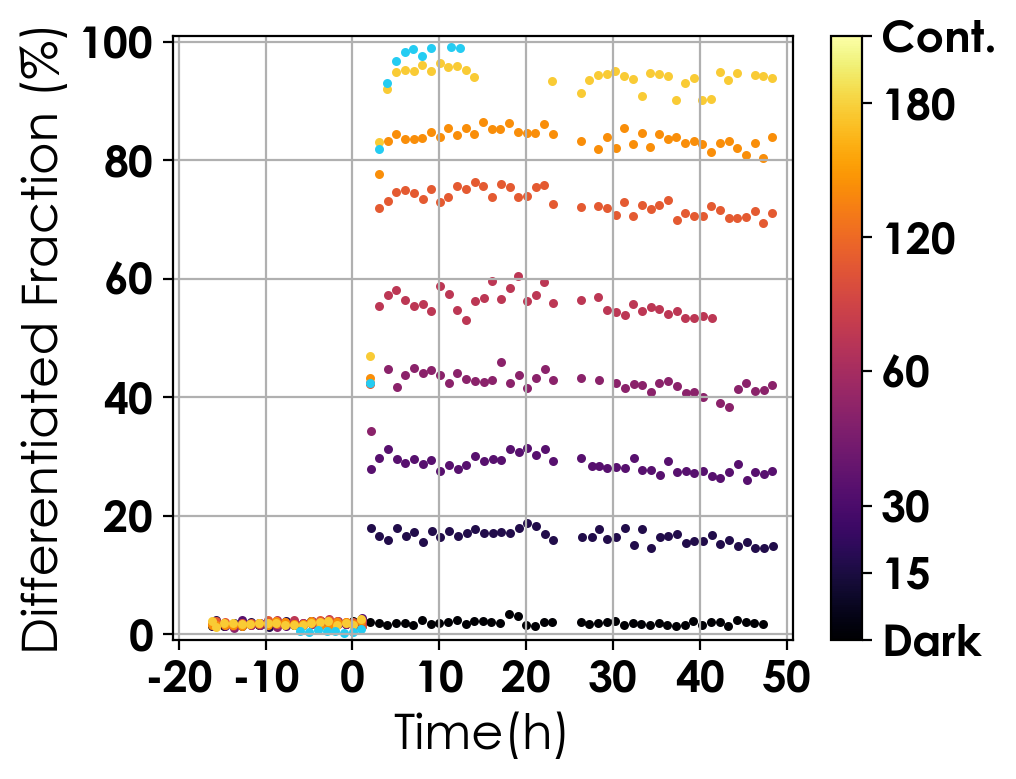

In [6]:
evenly_spaced_interval = np.linspace(0, 1,9)
fs = 18
colors = [plt.cm.inferno(x) for x in evenly_spaced_interval]

fig, (ax1) = plt.subplots(1,1,figsize=(5, 4), dpi=200, facecolor='w', edgecolor='k')
thresh1 = 0.5
thresh2 = 0.5
thresh_mc = 10
thresh_mn = 200
thresh_fp = [10, 200,50,100]
# fps = ['mCerulean','mNeonGreen','SSC-HLin']
fps = ['GRN-V-HLin','GRN-B-HLin','SSC-HLin']

sz = 5
t_delc = [16]
t_del1 = [0,42,66,67]
t_del2 = [0,42,66,67]
t_del3 = [0,21,42,45,57,65,66]
t_del4 = [0,42,58,59,60,61,62,63,64,65,66]
t_del7 = [0,33,34,35,36,37,38,39,40,42,62,66,67]
t_del5 = [0,42,65,66]
t_del6 = [0,42,65,66]
t_del8 = [0,42,65,66,67]
t_dels = [t_del1,t_del2,t_del3,t_del4,t_del5,t_del6,t_del7,t_del8]
for jj,rid in enumerate([8,1,2,3,4,5,6,7]):

    _,rec_fraction= rec_multi_vessel(fig,all_data1[rid], colors[jj],t_shift = 21.16,t_del = t_dels[rid-1],tc = 29,stats =False)
_,rec_fraction= rec_multi_vessel(fig,all_data[8], '#24ccf2',t_shift = 8.58,t_del = t_delc,tc = 17,stats =False)

cbar = fig.colorbar(plt.cm.ScalarMappable( cmap='inferno'), ax=ax1, ticks=[0, 1/9,2/9,4/9,6/9,8/9,9/9])
cbar.set_alpha(1)
cbar.draw_all()

cbar.ax.set_yticklabels(['Dark','15', '30', '60','120','180','Cont.'], fontsize=fs-2,**cgfont) 

ax1.set_xlim(-20.7,50.7)
ax1.set_ylim(-1,101)
ax1.grid(True)
ax1.set_xlabel('Time(h)', fontsize=fs,**cgfont)
xticks = [-20,-10,0,10,20,30,40,50]
yticks = [0,20,40,60,80,100]
ax1.set_ylabel('Differentiated Fraction (%)', fontsize=fs,**cgfont)
ax1.set_xticks(xticks) 
ax1.set_xticklabels([str(i) for i in xticks], fontsize=fs-2,**cgfont)
ax1.set_yticks(yticks) 
ax1.set_yticklabels([str(i) for i in yticks], fontsize=fs-2,**cgfont)

plt.savefig('../plots'  +'/Figure2b.eps',bbox_inches = 'tight')
plt.savefig('../plots'  +'/Figure2b.png',bbox_inches = 'tight')
plt.savefig('../plots'  +'/Figure2b.svg',bbox_inches = 'tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript back

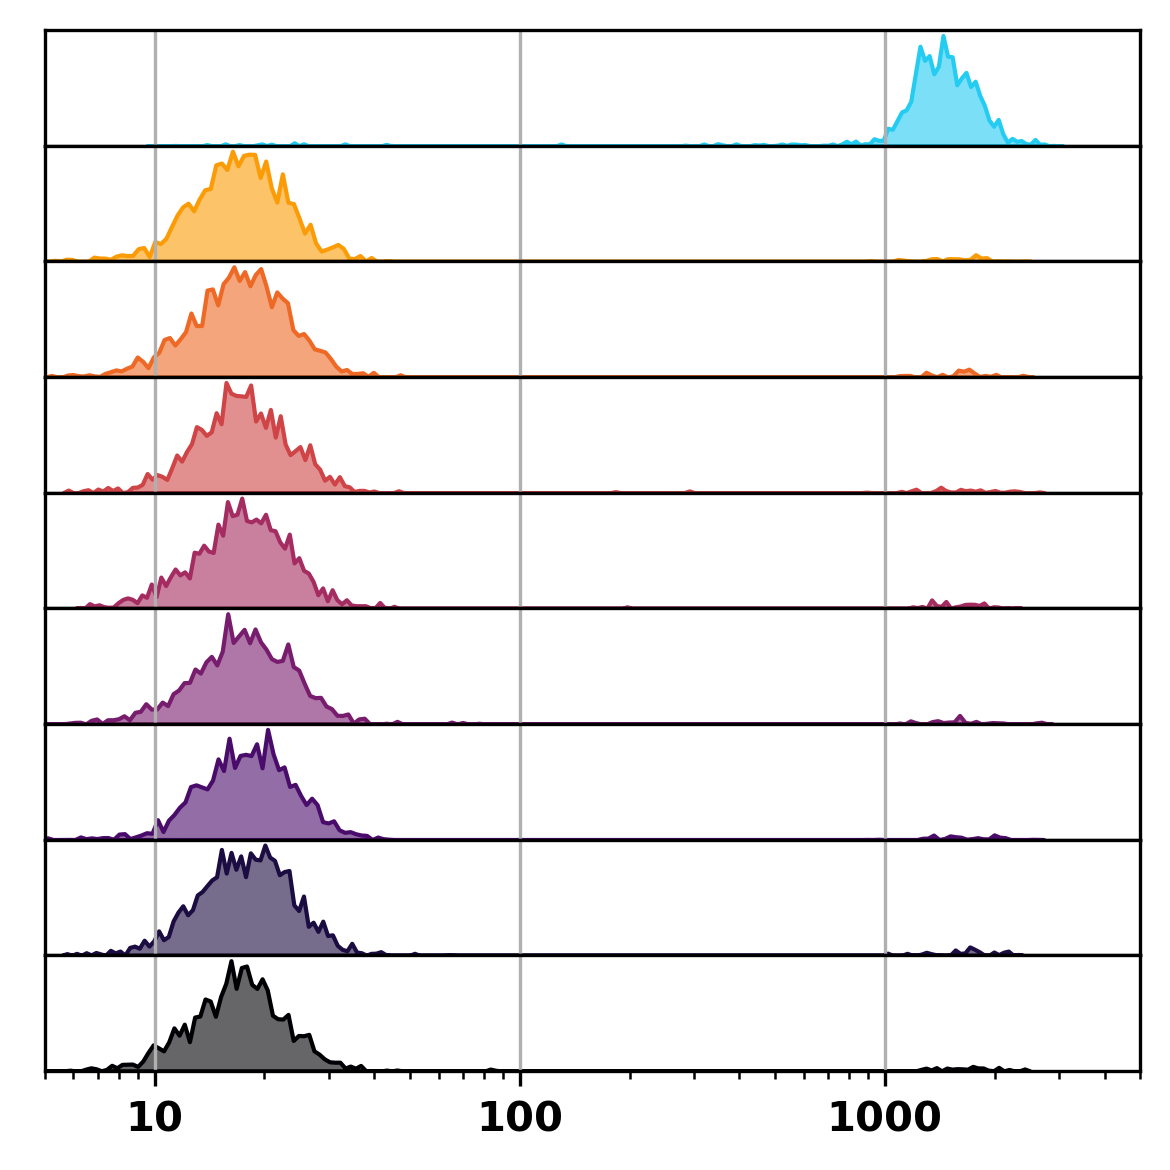

In [10]:
tp =7
# fp ='mNeonGreen'
fp = 'GRN-B-HLin'
fs =18
fig = plt.figure(figsize = (4,4), dpi =300, edgecolor ='w')
gs = fig.add_gridspec(9, hspace=0)
axes = gs.subplots(sharex=True, sharey=False)
axes = np.flip(axes)
evenly_spaced_interval = np.linspace(0, 1,len(axes)+1)
c1 = '#07cbd9'
c2 = '#07d942'
c2g = matplotlib.colors.LinearSegmentedColormap.from_list("", [c1,c2])
colors = [plt.cm.inferno(x) for x in evenly_spaced_interval]
hh = []
hhc = []
cc = 30
for rid in [8,1,2,3,4,5,6,7]:
    hh.append(hist_data(all_data1,rid,fp,(cc,cc+2)))
hhc.append(hist_data(all_data,8,fp,(17,19)))

for jj,ax in enumerate(axes[:-1]):
    sns.kdeplot(np.array(hh[jj]),ax =ax, bw_method = 0.1,color =colors[jj],  bw_adjust=0.1,log_scale = 10,fill =True,alpha=0.6)

    ax.set_yticks([])
    ax.set_xscale('log')
    ax.grid(False)
    ax.set_xlim(5,5000)

    ax.grid(True)
    ax.set_ylabel('')
sns.kdeplot(np.array(hhc[0]),ax =axes[-1], bw_method = 0.1,color ='#24ccf2',  bw_adjust=0.1,log_scale = 10,fill =True,alpha=0.6)

axes[-1].set_yticks([])
axes[-1].set_xscale('log')
axes[-1].grid(True)
axes[-1].set_xlim(5,5000)
xticks = [10,100,1000]

axes[-1].set_xticks(xticks)
axes[-1].set_xticklabels([str(i) for i in xticks])
axes[-1].set_ylabel('')
axes[-1].set_xlabel('mNeonGreen Intensity (A.U.)', fontsize=12,**cgfont)

fig.tight_layout()
plt.savefig('../plots'+'/Figure2c.eps',bbox_inches = 'tight')
plt.savefig('../plots' +'/Figure2c.png',bbox_inches = 'tight')
plt.savefig('../plots' +'/Figure2c.svg',bbox_inches = 'tight')

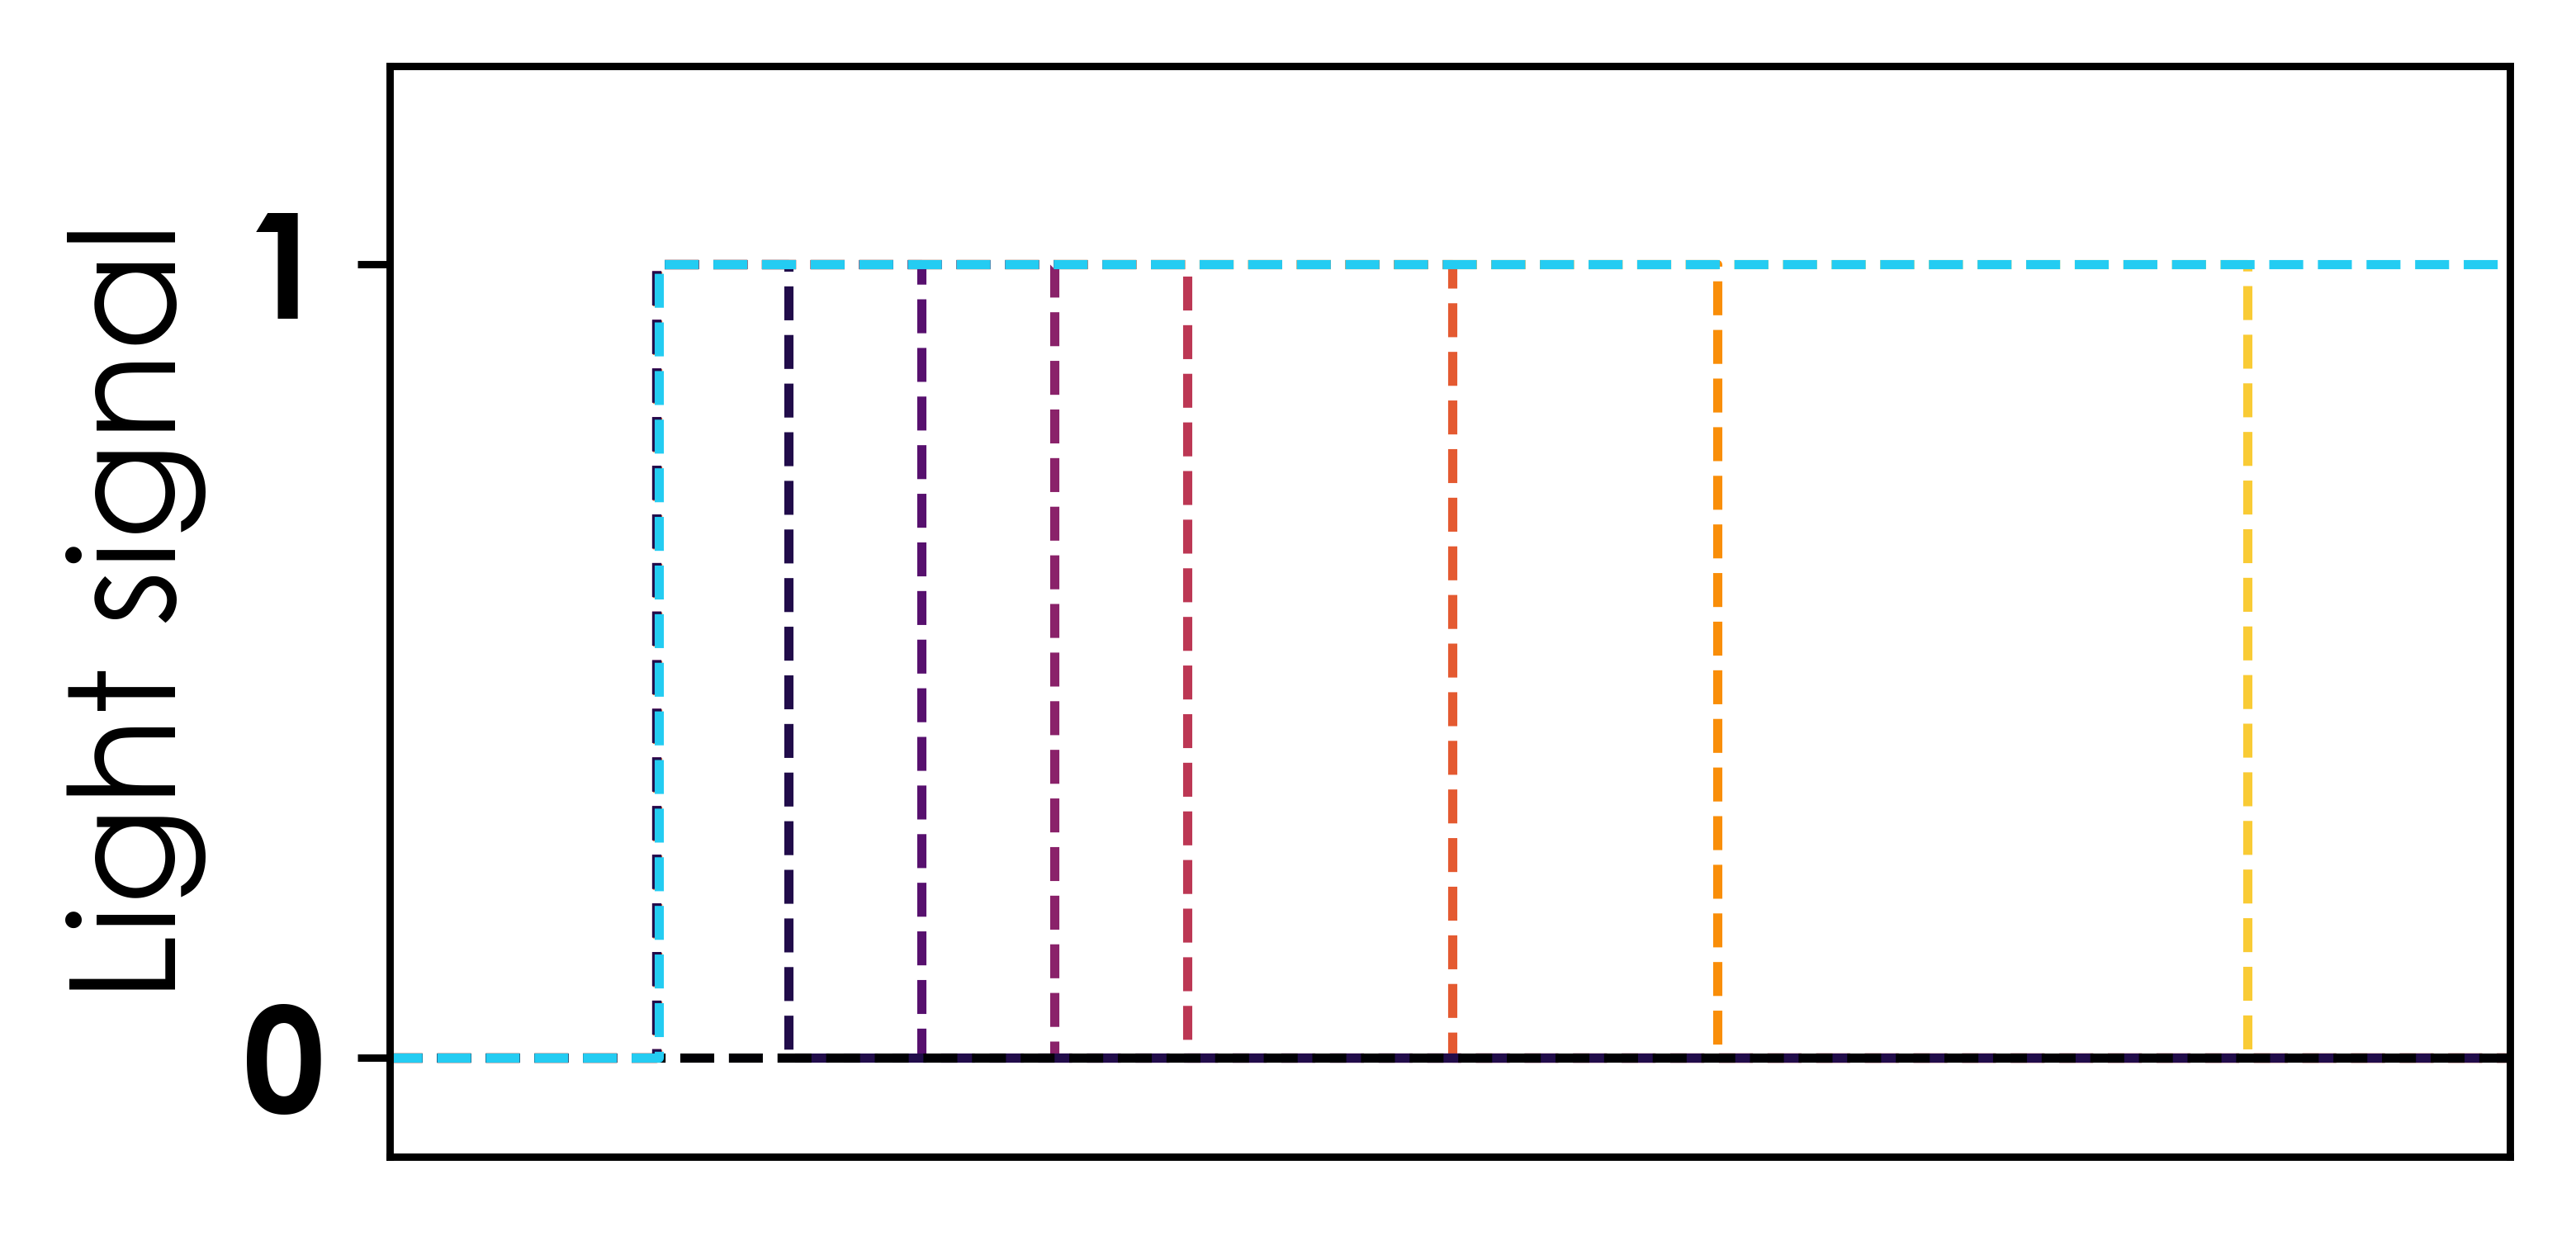

In [8]:
fig, ax1 = plt.subplots(1,1,figsize=(4,2),dpi = 800)
evenly_spaced_interval = np.linspace(0, 1,9)
ls = '--'
lw = 1
colors = [plt.cm.inferno(x) for x in evenly_spaced_interval]

for jj,rid in enumerate([7,6,5,4,3,2,1]):
    df_leds = all_data1[rid].data_to_df('LEDs')
    ax1.plot(df_leds['rel_time_hrs']-21.16,df_leds['intensity'],color = colors[rid],ls = ls,lw = lw)


df_leds = all_data1[8].data_to_df('LEDs')
ax1.plot(df_leds['rel_time_hrs']-21.16,df_leds['intensity'],color = colors[0],ls = ls,lw = lw)
df_leds = all_data[8].data_to_df('LEDs')
ax1.plot(df_leds['rel_time_hrs']-8.58,df_leds['intensity'],color = '#24ccf2',ls = ls,lw = lw)

ax1.set_xlim(-0.5,3.5)

ax1.set_xticks([])
xticklabels =[ '0','','1','','2','','3','','4','','5','','6','','7'] 
xticklabels =[]
ax1.set_xticklabels(xticklabels,fontsize = fs-2,**cgfont)
ax1.set_ylim(-5,50)
ax1.set_yticks([0,40])
ax1.set_yticklabels(['0','1'], fontsize=fs-2,**cgfont)
ax1.set_ylabel('Light signal',fontsize = fs-2,**cgfont)
ax1.set_xlabel('',fontsize = fs,**cgfont)

fig.tight_layout()
plt.savefig('../plots'  +'/Figure2a_top.eps',bbox_inches = 'tight')
plt.savefig('../plots'  +'/Figure2a_top.png',bbox_inches = 'tight')
plt.savefig('../plots'  +'/Figure2a_top.svg',bbox_inches = 'tight')

C:\Users\lifeware\miniconda3\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; pa

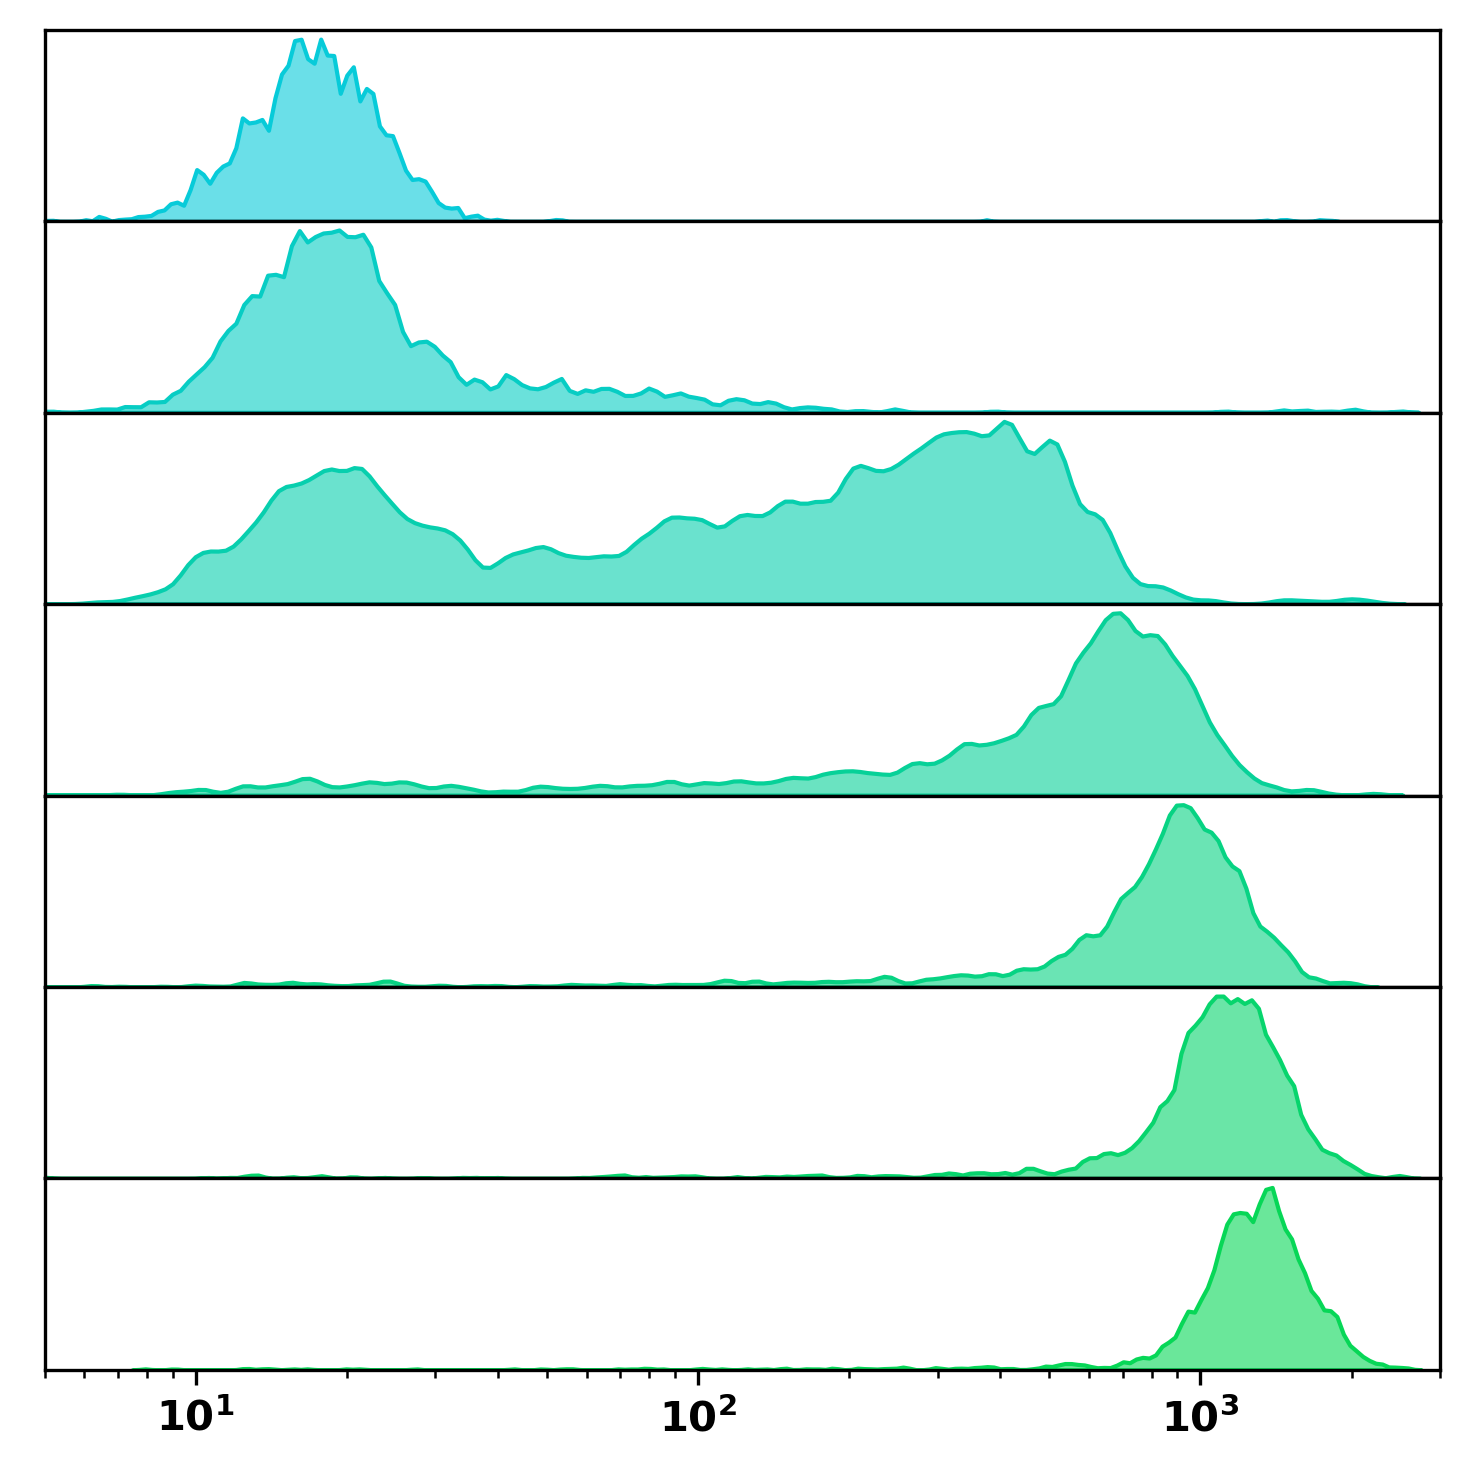

In [9]:
def hist_data_ts(data,rid,fp,tps):
    data = data[rid]
    gk = data.cells.groupby('rel_time_hrs')
    t= np.unique(np.array(data.cells['rel_time_hrs']))
    hist_data = []
    for jj in range(1,np.size(t)+1):
        if jj>tps[1]:
            break
        if (jj > tps[0]) & (jj< tps[1]):
            lk = gk.get_group(t[jj-1])
            
            sz_lk = lk.loc[(lk['gating-metric'] >= thresh1)]
            dbf_lk = sz_lk.loc[(sz_lk['doublet-metric'] <= thresh2)]
            db_lk = dbf_lk.loc[(dbf_lk['mCerulean'] > thresh_mc) |(dbf_lk['mNeonGreen'] > thresh_mn) ]
            hist_data.append( np.asarray(db_lk[fp]/db_lk['SSC-HLin']*db_lk['SSC-HLin'].mean()))
    return(hist_data)

rid =8
thresh1 = 0.5
thresh2 = 0.5
thresh_mc = 10
thresh_mn = 200
thresh_fp = [10, 200,50,100]
# fps = ['mCerulean','mNeonGreen','SSC-HLin']
fps = ['GRN-V-HLin','GRN-B-HLin','SSC-HLin']

# fp ='mNeonGreen'
fp = 'GRN-B-HLin'
fig = plt.figure(figsize = (5,5), dpi =300, edgecolor ='w')
gs = fig.add_gridspec(7, hspace=0)
axes = gs.subplots(sharex=True, sharey=False)
evenly_spaced_interval = np.linspace(0, 1,len(axes)+1)
bins = [0,3000,7500]
c1 = '#07cbd9'
c2 = '#07d942'
c2g = matplotlib.colors.LinearSegmentedColormap.from_list("", [c1,c2])
colors = [c2g(x) for x in evenly_spaced_interval]
hh = hist_data_ts(all_data,rid,fp,(6,15))

for jj,ax in enumerate(axes):
    sns.kdeplot(np.array(hh[jj]),ax =ax, bw_method = 0.2,color =colors[jj],  bw_adjust=0.2,log_scale = 10,fill =True,alpha=0.6)
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xscale('log')
    ax.set_xlim(5,3000)
fig.tight_layout()

plt.savefig('../plots' +'/Figure1b.eps',bbox_inches = 'tight')
plt.savefig('../plots' +'/Figure1b.png',bbox_inches = 'tight')
plt.savefig('../plots' +'/Figure1b.svg',bbox_inches = 'tight')